We will wiork with dataset from employees database.
Let's explore and perform different manipulation with dataset using SQL and pandas to discover insights.

First of all let's create a connection to the 'employees' database.

In [1]:
!pip install mysql-connector-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 35.8 MB/s eta 0:00:00


In [2]:
import mysql.connector
from mysql.connector.connection import MySQLConnection
import datetime
import pandas as pd

In [3]:
con = mysql.connector.connect(user='user1', password='7oygWy6P',
                              host='3.68.62.36',
                              database='employees')

1. Let's start with  the number of employees hired each year based on their hire_date using **pandas.read_sql**. We'll store the result in the variable **df** and then display its contents on the screen.

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
from IPython.display import display
cursor=con.cursor()

sql = """
SELECT substr(hire_date, 1, 4) AS hire_year, COUNT(*) AS emp_num
FROM employees
GROUP BY hire_year
ORDER BY hire_year ASC;
"""

df = pd.read_sql(sql, con);
display(df)

,hire_year,emp_num
0,1985,35316
1,1986,36150
2,1987,33501
3,1988,31436
4,1989,28394
5,1990,25610
6,1991,22568
7,1992,20402
8,1993,17772
9,1994,14835


2. I will select the earliest and latest hire dates of employees using **con.cursor().**

In [7]:
cursor=con.cursor()

sql="""
select MAX(hire_date), MIN(hire_date) FROM employees
"""
cursor.execute(sql)

cursor.fetchall()

[(datetime.date(2000, 1, 28), datetime.date(1985, 1, 1))]

3. Let's gather information about the most recent salary for each employee in the database. Using **con.cursor()**, We will select from the salaries table each employee's ID, the most recent salary in the database (corresponding to the latest to_date), and the associated *from_date* and *to_date* for that salary.

In [8]:
from IPython.display import display

cursor=con.cursor()

query = """

SELECT s.emp_no, s.salary, s.from_date, s.to_date
FROM salaries s
INNER JOIN (
    SELECT emp_no, MAX(from_date) AS from_date, MAX(to_date) AS to_date
    FROM salaries
    GROUP BY emp_no
) AS max_date ON s.emp_no = max_date.emp_no AND s.to_date = max_date.to_date AND s.from_date = max_date.from_date
"""
cursor.execute(query)
rows = cursor.fetchall()

field_names = [i[0] for i in cursor.description]# Getting column names
res=pd.DataFrame(rows, columns=field_names)# Record the results in a DataFrame

display(res.columns)
display("DataFrame size:",res.shape)
display(res.head(3))

Index(['emp_no', 'salary', 'from_date', 'to_date'], dtype='object')

'DataFrame size:'

(300024, 4)

,emp_no,salary,from_date,to_date
0,10001,88958,2002-06-22,9999-01-01
1,10002,72527,2001-08-02,9999-01-01
2,10003,43311,2001-12-01,9999-01-01


4. In the resulting selection stored in the variable **res**, we will determine how many **to_date values** are equal to 9999-01-01 and how many are not. It is crucial to understand the data type of the to_date column to accurately perform this task. we will first identify the data type, then write a filter to output the required results.

In [9]:
from datetime import datetime,date

In [10]:
date(9999,1,1)
(res.to_date==date(9999,1,1)).value_counts()

,count
to_date,
True,240124
False,59900


5. We will visually display the distribution (histogram) of salaries for employees who are still working at the company, using the result from the previous task. Employees who are still with the company are those whose to_date is **9999-01-01**. We'll make sure to label the chart and axes appropriately.

In [11]:
import matplotlib.pyplot as plt

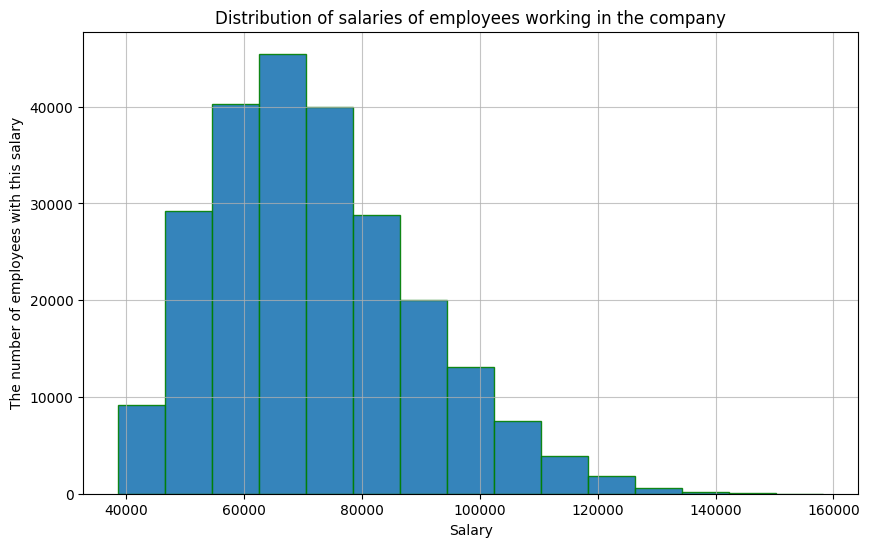

In [13]:
res['to_date'] = res['to_date'].astype(str)

employee = res[res['to_date'] == '9999-01-01']

plt.figure(figsize=(10, 6))
plt.hist(employee['salary'], bins=15, edgecolor='g', alpha=0.9)
plt.title('Distribution of salaries of employees working in the company')
plt.xlabel('Salary')
plt.ylabel('The number of employees with this salary')
plt.grid(alpha=0.75)
plt.show()

6. Let's create a graphic which shows the relationship between the number of employees hired and the year of hire. After all, we retrieved the data from the database for a reason! We'll rename the columns of the DataFrame either using pandas methods or in the SQL query from the previous task. Additionally, to ensure the graph is accurate, we’ll sort the years in ascending order, which can be done either in pandas or within the SQL query.

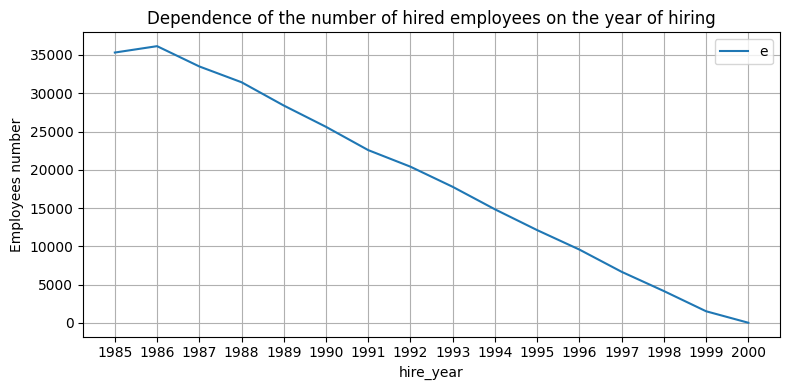

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(df['hire_year'], df['emp_num'], )
plt.xlabel('hire_year')
plt.ylabel('Employees number')
plt.title('Dependence of the number of hired employees on the year of hiring')
plt.legend('emp_num')
plt.grid(True)
plt.tight_layout()
plt.show()


7. Using SQL, we will find the number of full years that workers in the position of Engineer, who are no longer with the company (i.e., their to_date is not set to the default value), spent in that position. The position is stored in the title column in the titles table. We will calculate the number of years in the position using a function like timestampdiff.

In [ ]:
query = """
SELECT TIMESTAMPDIFF(YEAR, t.from_date, t.to_date) AS duration, t.from_date, t.to_date
FROM employees AS e
JOIN titles AS t ON e.emp_no = t.emp_no
WHERE t.title = 'Engineer' AND t.to_date != '9999-01-01'
"""
df_years = pd.read_sql(query, con)
display(df_years)

,duration,from_date,to_date
0,9,1986-12-01,1995-12-01
1,5,1990-02-18,1995-02-18
2,8,1992-12-18,2000-12-18
3,8,1987-04-03,1995-04-03
4,5,1995-03-20,2001-03-19
...,...,...,...
84015,9,1989-11-23,1998-11-23
84016,5,1989-07-30,1994-07-30
84017,0,1993-02-22,1993-10-27
84018,6,1996-05-13,2002-05-13


8. Using the data in df_years, Let's create a histogram to show the number of years that people with the title Engineer held their position.

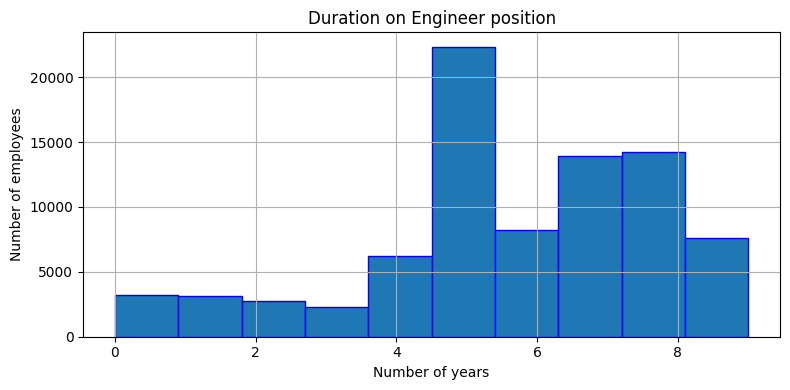

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(df_years['duration'], edgecolor='b')
plt.title('Duration on Engineer position')
plt.xlabel('Number of years')
plt.ylabel('Number of employees')
plt.grid(True)
plt.tight_layout()

DO NOT FORGET TO CLOSE THE CONNECTION TO THE BASE :)

In [14]:
con.close()